In [1]:
import pandas as pd
import os
import cv2
import csv
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import h5py
from torchvision import transforms
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing, datasets

In [2]:
def imageGenerator():
    input_folder = r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\data'
    output_folder = r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\converted_data'
    datas = []
    img_size = (256,256)
    for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith('.mat'):
            file_path = os.path.join(input_folder,file_name)
            
            with h5py.File(file_path, 'r') as f:
                image = np.array(f['cjdata/image']).T
                label = int(np.array(f['cjdata/label'])[0,0])
    
            image = image.astype(np.float64)
            im_norm = 255*(image-image.min())/(image.max()-image.min())
            im_uint8 = im_norm.astype(np.uint8)

            file_name_base = os.path.splitext(file_name)[0]
            output_file_path = os.path.join(output_folder,file_name_base + '.jpg')
    
            im_pil = Image.fromarray(im_uint8)
            im_pil = im_pil.resize(img_size)
            datas.append((np.array(im_pil,dtype=np.float32),label))
            
            im_pil.save(output_file_path)
    #return datas

In [3]:
#imageGenerator()

In [4]:
def imageProcesser():
    input_folder = r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\data'
    datas = []
    img_size = (256,256)
    for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith('.mat'):
            file_path = os.path.join(input_folder,file_name)
            
            with h5py.File(file_path, 'r') as f:
                label = int(np.array(f['cjdata/label'])[0,0])-1
                tumor_border = np.array(f['cjdata/tumorBorder']).T
                tumor_mask = np.array(f['cjdata/tumorMask']).T

         
            datas.append((label))
    return datas

In [5]:
input_folder = r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\converted_data'

X = []
for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith('.jpg'):
            file_path = os.path.join(input_folder,file_name)
            
            img = preprocessing.image.load_img(file_path,target_size=(256, 256),
                                                  color_mode="grayscale")
            image_array = preprocessing.image.img_to_array(img)
            image_array = image_array/255.0

            X.append(image_array)

In [6]:
y = imageProcesser()

In [7]:
#data = pd.concat([X,pd.DataFrame()])

In [8]:
input_folder = r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\Normal'
for file_name in sorted(os.listdir(input_folder)):
        if file_name.endswith('.jpg'):
            file_path = os.path.join(input_folder,file_name)
            
            img = preprocessing.image.load_img(file_path,target_size=(256, 256),
                                                  color_mode="grayscale")
            image_array = preprocessing.image.img_to_array(img)
            image_array = image_array/255.0

            X.append(image_array)
            y.append(3)

In [9]:
labels = ['meningioma', 'glioma', 'pituitary tumor','nothing']

In [10]:
datageneration = preprocessing.image.ImageDataGenerator(
    rotation_range=20,       # forgatás (fokban)
    width_shift_range=0.1,   # vízszintes eltolás
    height_shift_range=0.1,  # függőleges eltolás
    zoom_range=0.1,          # nagyítás/kicsinyítés
    horizontal_flip=True,    # vízszintes tükrözés
    fill_mode='nearest'  
)

In [11]:
X = np.array(X, dtype="float32")
y = np.array(y, dtype="int")

In [12]:
print("x len: ",len(X))
print("y len: ",len(y))

x len:  4813
y len:  4813


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
print("x len: ",len(X_test))
print("y len: ",len(y_test))

x len:  1589
y len:  1589


In [15]:
model = models.Sequential() 
model.add(layers.Input(shape=(256, 256, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(4,activation='softmax')) # Többosztályos osztályozás (pl. glioma, meningeoma, stb.)


In [16]:
print("x len: ",len(X_test))
print("y len: ",len(y_test))

x len:  1589
y len:  1589


In [17]:
train_generated = datageneration.flow(X_train,y_train,batch_size=32)

In [18]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(train_generated, epochs=40, validation_data=(X_test,y_test))

C:\Users\marto\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 53s 492ms/step - accuracy: 0.4378 - loss: 1.4795 - val_accuracy: 0.7911 - val_loss: 0.5112
Epoch 2/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 48s 470ms/step - accuracy: 0.7606 - loss: 0.5813 - val_accuracy: 0.8043 - val_loss: 0.4703
Epoch 3/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 466ms/step - accuracy: 0.7799 - loss: 0.5225 - val_accuracy: 0.8452 - val_loss: 0.4057
Epoch 4/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 466ms/step - accuracy: 0.8128 - loss: 0.4645 - val_accuracy: 0.8641 - val_loss: 0.3729
Epoch 5/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 465ms/step - accuracy: 0.8255 - loss: 0.4284 - val_accuracy: 0.8641 - val_loss: 0.3353
Epoch 6/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 463ms/step - accuracy: 0.8339 - loss: 0.3959 - val_accuracy: 0.8483 - val_loss: 0.3704
Epoch 7/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 48s 469ms/step - accuracy: 0.8228 - loss: 0.4210 - val_accuracy: 0.8880 - val_loss: 0.2937
Epoch 8/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 464ms/step - accuracy: 0.8525 - loss: 0

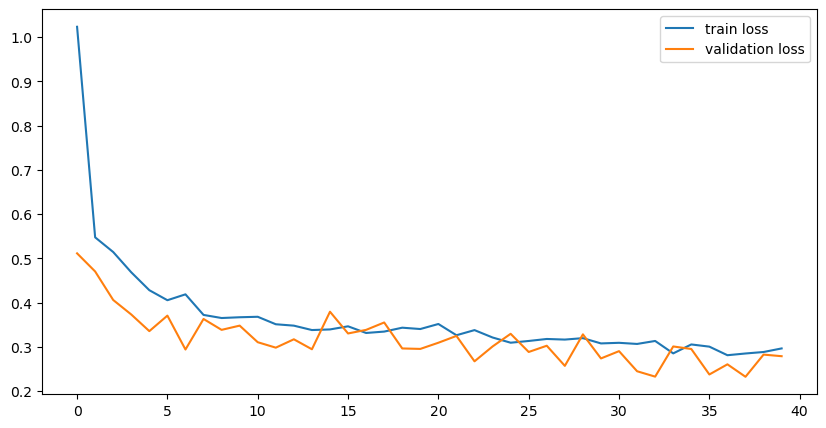

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [20]:
import joblib as jl
#model.save('C:/Users/marto/Desktop/Thesis/backend/models/BrainTumorClassificationModel.h5')
#jl.dump(history,'C:/Users/marto/Desktop/Thesis/backend/models/BrainTumorClassificationHistory.pkl')

In [21]:
img = np.expand_dims(X[1],axis=0)
print ("Type:", type(img))
print("Shape:", img.shape)
print("Min:", img.min(), "Max:", img.max())
print("Dtype:", img.dtype)

Type: <class 'numpy.ndarray'>
Shape: (1, 256, 256, 1)
Min: 0.0 Max: 1.0
Dtype: float32


In [22]:
pred = model.predict(img)
pred_class = np.argmax(pred,axis=1).tolist()
pred_prob = np.max(pred)
print(f"Predikált osztály: {pred_class}, valószínűség: {pred_prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Predikált osztály: [0], valószínűség: 0.98


In [23]:
pred = model.predict(np.expand_dims(X[0],axis=0))
pred_class = np.argmax(pred,axis=1).tolist()
pred_prob = np.max(pred)
print(f"Predikált osztály: {pred_class}, valószínűség: {pred_prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predikált osztály: [0], valószínűség: 0.87


In [24]:
pred = model.predict(np.expand_dims(X[2],axis=0))
pred_class = np.argmax(pred,axis=1).tolist()
pred_prob = np.max(pred)
print(f"Predikált osztály: {pred_class}, valószínűség: {pred_prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predikált osztály: [0], valószínűség: 0.54


In [25]:
pred = model.predict(np.expand_dims(X[3],axis=0))
pred_class = np.argmax(pred,axis=1).tolist()
pred_prob = np.max(pred)
print(f"Predikált osztály: {pred_class}, valószínűség: {pred_prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predikált osztály: [2], valószínűség: 0.99


In [26]:
y[1]

0

In [27]:
y[21]

2

In [28]:
sorted(os.listdir(input_folder))[:10]


['43284106.jpg',
 '43284122.jpg',
 '43284138.jpg',
 '43284154.jpg',
 '43284170.jpg',
 '43284186.jpg',
 '43284202.jpg',
 '43284218.jpg',
 '43284234.jpg',
 '43284250.jpg']

In [29]:
sorted(os.listdir(r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\data'))[:10]

['.ipynb_checkpoints',
 '1.mat',
 '10.mat',
 '100.mat',
 '1000.mat',
 '1001.mat',
 '1002.mat',
 '1003.mat',
 '1004.mat',
 '1005.mat']

0


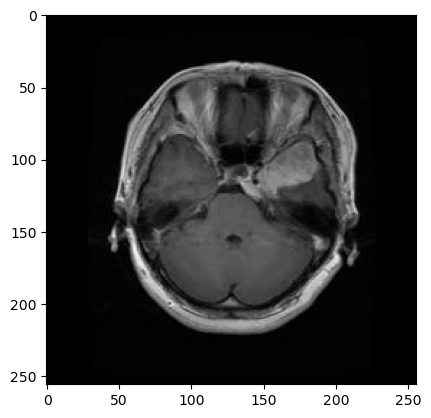

In [30]:
print(y[0])
img = cv2.imread(r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\converted_data\1.jpg')
plt.imshow(img,cmap='gray')
plt.show()

0


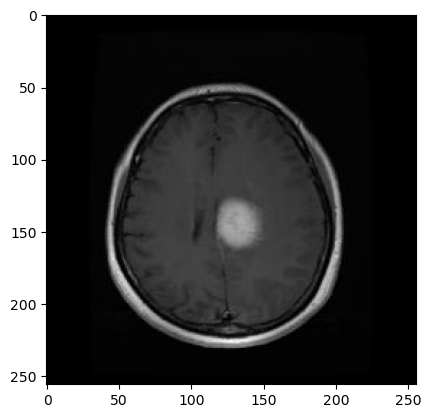

In [31]:
print(y[1])
img = cv2.imread(r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\converted_data\10.jpg')
plt.imshow(img,cmap='gray')
plt.show()

0


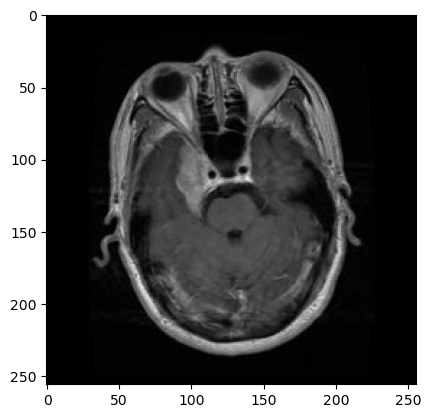

In [32]:
print(y[2])
img = cv2.imread(r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\converted_data\100.jpg')
plt.imshow(img,cmap='gray')
plt.show()

2


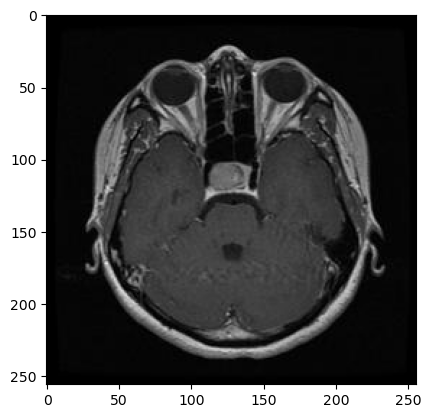

In [33]:
print(y[3])
img = cv2.imread(r'C:\Users\marto\Desktop\Szakdolgozat\pogram\brainTumor\converted_data\1000.jpg')
plt.imshow(img,cmap='gray')
plt.show()

In [34]:
print("x len: ",len(X_test))
print("y len: ",len(y_test))

x len:  1589
y len:  1589


In [35]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score, classification_report

print("Pontosság:", accuracy_score(y_test, predicted_classes))
print("\nRészletes riport:\n", classification_report(y_test, predicted_classes))

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step
Pontosság: 0.9005663939584645

Részletes riport:
               precision    recall  f1-score   support

           0       0.73      0.67      0.70       237
           1       0.90      0.84      0.87       465
           2       0.86      0.99      0.92       323
           3       0.99      1.00      1.00       564

    accuracy                           0.90      1589
   macro avg       0.87      0.87      0.87      1589
weighted avg       0.90      0.90      0.90      1589



In [36]:
y[180]

2

In [37]:
pred = model.predict(np.expand_dims(X[180],axis=0))
pred_class = np.argmax(pred,axis=1).tolist()
pred_prob = np.max(pred)
print(f"Predikált osztály: {pred_class}, valószínűség: {pred_prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predikált osztály: [2], valószínűség: 0.98


In [38]:
#np.save('C:/Users/marto/Desktop/Thesis/backend/brainTumor_y_test.npy',y_test)

In [39]:
len(y_test)

1589

In [40]:
#np.save('C:/Users/marto/Desktop/Thesis/backend/brainTumor_X_test.npy', X_test)  


In [41]:
len(X_test)

1589